## Configure Pyspark

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"
import findspark
findspark.init()

In [3]:
!pip install sparknlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.4/489.4 kB 10.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import json

import sparknlp
import pyspark.sql.functions as F

from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [5]:
import pandas as pd
pd.set_option('display.max_columns',100, 'display.max_colwidth',1000, 'display.max_rows',1000, 
              'display.float_format', lambda x: '%.2f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [7]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

## Read in data

In [8]:
from pyspark.sql.functions import *
spark = sparknlp.start()

In [9]:
# connect to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
filePath = "drive/MyDrive/Colab Notebooks/comments.parquet"
comments_df = spark.read.format("parquet").option("header","true").load(filePath)

## Prepare Sexism Classification Model

In [11]:
import pandas as pd
import numpy as np
import json

import sparknlp
import pyspark.sql.functions as F

from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [12]:
spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.4.2
Apache Spark version: 3.1.2


In [13]:
MODEL_NAME='classifierdl_use_cyberbullying'

In [14]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")


sentimentdl = ClassifierDLModel.pretrained(name=MODEL_NAME)\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("sentiment")

nlpPipeline = Pipeline(stages = [documentAssembler,
                                 use,
                                 sentimentdl])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_cyberbullying download started this may take some time.
Approximate size to download 21.3 MB
[OK!]


In [15]:
comments_df.select('comment_text').show(truncate=False)

+--------------------------------------------------------------------------------------------------+
|comment_text                                                                                      |
+--------------------------------------------------------------------------------------------------+
|Old video...come on pornhub...you can do better than this                                         |
|Wow 😍                                                                                            |
|Does anyone know what is the IG account from this channel ?                                       |
|Clickbait in porn... I just totally lost my faith in humanity.                                    |
|I would definitely suck a fart out of your asshole!                                               |
|Super hot, why lie                                                                                |
|big toys are fine, but you make me die when you stick your fingers in the A-hole. oh fuck i

In [16]:
text_list = [row.comment_text for row in comments_df.select("comment_text").collect()]

In [17]:
df = spark.createDataFrame(text_list, StringType()).toDF("text")
result=nlpPipeline.fit(df).transform(df)

In [18]:
results_df = result.select(F.explode(F.arrays_zip(result.document.result, 
                                     result.sentiment.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("document"),
              F.expr("cols['1']").alias("sentiment"))

In [ ]:
results_df.show(truncate=False)

+--------------------------------------------------------------------------------------------------+---------+
|document                                                                                          |sentiment|
+--------------------------------------------------------------------------------------------------+---------+
|Old video...come on pornhub...you can do better than this                                         |neutral  |
|Wow 😍                                                                                            |neutral  |
|Does anyone know what is the IG account from this channel ?                                       |neutral  |
|Clickbait in porn... I just totally lost my faith in humanity.                                    |sexism   |
|I would definitely suck a fart out of your asshole!                                               |sexism   |
|Super hot, why lie                                                                                |sexism   |
|b

In [ ]:
sexism = results_df.groupBy('sentiment').count().toPandas()
sexism

,sentiment,count
0,None,5286
1,sexism,309128
2,neutral,543402
3,racism,1911


In [ ]:
# remove none
sexism = sexism.drop([0])

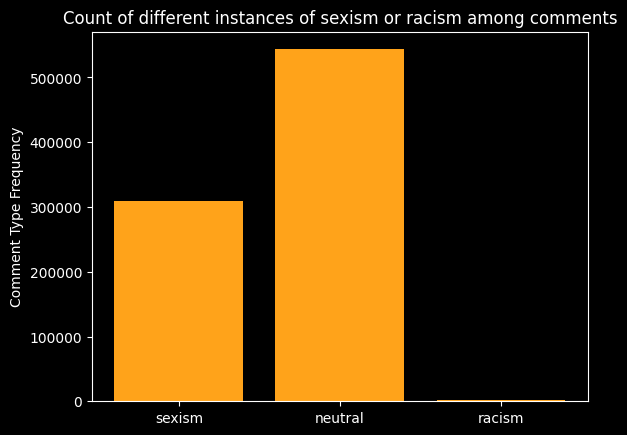

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the background color to black
plt.style.use('dark_background')

plt.close('all')
x = sexism['sentiment'].values
y = sexism['count'].values
plt.title('Count of different instances of sexism or racism among comments')
plt.bar(x, y, color='#ffa31a')

plt.ylabel('Comment Type Frequency')
plt.xticks(x, ['sexism','neutral','racism']);

In [19]:
sentiment = udf(lambda x: TextBlob(x).sentiment[0] if x is not None else None)
spark.udf.register("sentiment", sentiment)
results_df = results_df.withColumn('sent_score',sentiment('document').cast('double'))

In [ ]:
results_df.select('sent_score').show()

+--------------------+
|          sent_score|
+--------------------+
|                 0.3|
|                 0.1|
|                 0.0|
|                 0.0|
|                 0.0|
| 0.29166666666666663|
|0.005555555555555554|
|                 0.8|
|                 0.0|
|                 0.5|
|                 0.0|
|-0.09062499999999996|
|  0.6000000000000001|
|                 0.5|
|                 0.0|
|                 0.5|
|                 1.0|
|                 0.5|
|                 0.0|
|                0.25|
+--------------------+
only showing top 20 rows



In [20]:
results_df.show(50, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+---------------------+
|document                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# plot sexism against sentiment
sent_df = (results_df.groupBy('sentiment')
                   .mean('sent_score')
              )
sent_df.show()

+---------+--------------------+
|sentiment|     avg(sent_score)|
+---------+--------------------+
|     null|0.015093464733926178|
|   sexism|  0.2021949577758019|
|  neutral| 0.17638094742209443|
|   racism|  0.0686026558250506|
+---------+--------------------+



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sent_df.toPandas()

In [ ]:
df

,sentiment,avg(sent_score)
0,None,0.02
1,sexism,0.20
2,neutral,0.18
3,racism,0.07


In [ ]:
# remove none
df = df.drop([0])

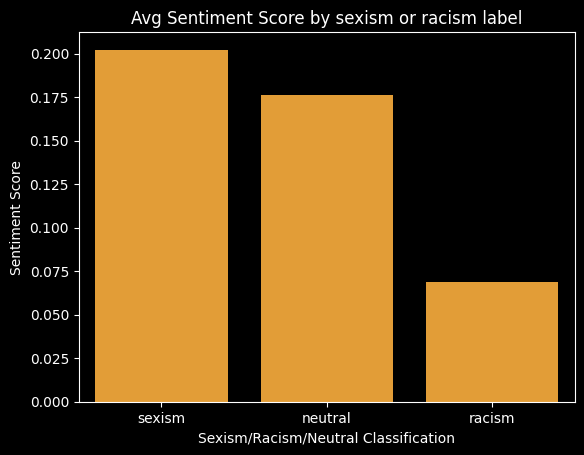

In [ ]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

sns.barplot(x='sentiment', y='avg(sent_score)', data=df, color='#ffa31a').set(title='Avg Sentiment Score by sexism or racism label', xlabel='Sexism/Racism/Neutral Classification', ylabel='Sentiment Score');